In [71]:
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder.appName('titanic').getOrCreate()

train = spark.read.csv('/home/ravisankar/Desktop/datasets/titanic/train.csv', inferSchema=True,header=True)
train_pd=pd.read_csv('/home/ravisankar/Desktop/datasets/titanic/train.csv')
train_shape=train_pd.shape
print(train_shape)

(891, 12)


In [72]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Survived: integer (nullable = true)



In [73]:
train.groupBy('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [75]:
train.createOrReplaceTempView('titanic_table')

In [76]:
spark.sql("SELECT Sex ,count(Sex) as gender_count,count(sex)*100/sum(count(sex)) over() as percent from titanic_table GROUP BY Sex").show()

+------+------------+-----------------+
|   Sex|gender_count|          percent|
+------+------------+-----------------+
|female|         314|35.24130190796858|
|  male|         577|64.75869809203142|
+------+------------+-----------------+



In [77]:
spark.sql("SELECT Sex, count(Sex) AS gender_count, \
100*count(sex)/sum(count(sex)) over() AS percent \
FROM titanic_table \
WHERE Survived = 1 \
GROUP BY sex").show()



+------+------------+------------------+
|   Sex|gender_count|           percent|
+------+------------+------------------+
|female|         233| 68.12865497076024|
|  male|         109|31.871345029239766|
+------+------------+------------------+



In [78]:
spark.sql("SELECT Sex, count(Sex) AS gender_count, \
100*count(sex)/sum(count(sex)) over() AS percent \
FROM titanic_table \
WHERE Survived = 1 \
GROUP BY sex").show()




+------+------------+------------------+
|   Sex|gender_count|           percent|
+------+------------+------------------+
|female|         233| 68.12865497076024|
|  male|         109|31.871345029239766|
+------+------------+------------------+



+------+-----------+-----------------+
|Pclass|class_count|          percent|
+------+-----------+-----------------+
|     1|        136|39.76608187134503|
|     3|        119| 34.7953216374269|
|     2|         87|25.43859649122807|
+------+-----------+-----------------+



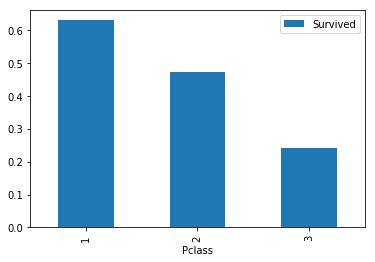

In [79]:
spark.sql("SELECT Pclass, count(Pclass) as class_count,\
         count(Pclass)*100/sum(count(Pclass)) over() AS percent \
         FROM titanic_table \
         WHERE Survived=1 GROUP BY Pclass").show()
import matplotlib.pyplot as plt
sex_table=train_pd.pivot_table(index="Pclass",values="Survived")
sex_table.plot.bar()
plt.show()

In [80]:
spark.sql("SELECT Age, count(Age) as age_count FROM titanic_table WHERE Survived == 1 GROUP BY Age ORDER BY age_count DESC").show()


+----+---------+
| Age|age_count|
+----+---------+
|24.0|       15|
|22.0|       11|
|36.0|       11|
|27.0|       11|
|35.0|       11|
|30.0|       10|
|32.0|        9|
|19.0|        9|
|18.0|        9|
|29.0|        8|
|31.0|        8|
|28.0|        7|
| 4.0|        7|
|48.0|        6|
|17.0|        6|
|42.0|        6|
|25.0|        6|
|40.0|        6|
|34.0|        6|
|33.0|        6|
+----+---------+
only showing top 20 rows



In [81]:
train_pd['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [84]:
#train.filter((train['Survived']==1)&(train['Age']>='14')).count()
train.filter((train['Survived']==1)&(train['Sex']=='female')&(train['Age']>=14)).count()
#train.filter((train['Survived']==1)&(train['Age']>='14')).count()

212

In [85]:
from pyspark.sql.functions import mean
mean = train.select(mean(train['Age'])).collect()
mean_age = mean[0][0]
train = train.na.fill(mean_age,['Age'])

In [101]:
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder,
                                StringIndexer)

In [102]:
Sex_indexer=StringIndexer(inputCol='Sex',outputCol='Sexindex')
Sex_encoder=OneHotEncoder(inputCol='Sexindex',outputCol='Sexvector')

Pclass_indexer=StringIndexer(inputCol='Pclass',outputCol='Pclassindex')
Pclass_encoder=OneHotEncoder(inputCol='Pclassindex',outputCol='Pclassvector')

Age_indexer=StringIndexer(inputCol='Age',outputCol='Ageindex')
Age_encoder=OneHotEncoder(inputCol='Ageindex',outputCol='Agevector')

In [103]:
assembler=VectorAssembler(inputCols=['PassengerId','Embarked','Pclassvector','Name','Sexvector','Agevector','SibSp','Parch','Ticket','Fare','Cabin'],outputCol='features')

In [104]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='Survived',featuresCol='features')

In [105]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[Sex_indexer, Pclass_indexer, Age_indexer, Sex_encoder,
                           Pclass_encoder, Age_encoder, assembler, dtc])

In [106]:
train_data,test_data = train.randomSplit([0.7,0.3])

In [108]:
model = pipeline.fit(train_data)
dtc_predictions = model.transform(test_data)

IllegalArgumentException: 'Data type string of column Embarked is not supported.\nData type string of column Name is not supported.\nData type string of column Ticket is not supported.\nData type string of column Cabin is not supported.'

In [109]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)

print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

NameError: name 'dtc_predictions' is not defined